# [課題]量子状態で計算をするとは？

第一回の実習で量子回路の書き方、IBMQ実機の使い方、簡単な量子状態の生成の仕方を学びました。しかし、量子状態を用いて実際に「計算」をするというのがどういうことか、まだ見えてこない人も多いのではないでしょうか。

量子計算をするとはどういうことかを一概に決めることはできませんし、それ自体がまだ世界中で盛んに研究されているトピックです。ただ、現在知られている量子コンピュータの実用法に共通する大まかな特徴を挙げるならば、以下の２点になります。

- **並列性を利用する**：Equal superposition状態で見たように、$n$量子ビットがあるとき、比較的簡単な操作で$2^n$個の計算基底が顕に登場する状態が作れます。また、この状態には全ての量子ビットが関与するため、どのビットに対するゲート操作も全ての計算基底に影響を及ぼします。つまり、各ゲート操作が常に$2^n$重の並列演算となります。
- **干渉を利用する**：量子振幅は複素数なので、二つの振幅が足し合わされるとき、それぞれの位相によって和の振幅の値が変わります。特に絶対値が等しく位相が逆である（$\pi$だけ異なる）場合和が0となるので、そのことを利用して回路の量子状態の重ね合わせから特定の計算基底を除くといったことが可能です。

並列性については第二回の実習で詳しく触れるので、ここでは干渉を計算に利用するということを、問題を解きながら実感してみましょう。

```{contents} 目次
---
local: true
---
```

$\newcommand{ket}[1]{|#1\rangle}$

## 問題1: 符号が反転している基底を見つける

実習で出てきたequal superposition状態

$$
H^{\otimes n} \ket{0} = \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} \ket{k}
$$

をそのまま測定すると、全ての整数$k$に対応するビット列が等しい確率で現れます。測定でビット列が現れる確率はそのビット列に対応する計算基底の振幅の絶対値自乗で決まるので、重ね合わせにおいてある整数$\tilde{k}$の符号だけ逆転している以下の状態でもやはり全ての整数が確率$1/2^n$で得られます。

$$
\frac{1}{\sqrt{2^n}} \left( \sum_{k \neq \tilde{k}} \ket{k} - \ket{\tilde{k}} \right)
$$

（一般には、全ての計算基底にバラバラに位相因子$e^{i\theta_{k}}$がかかっていても確率は同じです。）

さて、{doc}`後の実習 <grover>`で登場するグローバー探索というアルゴリズムは、上のように一つの計算基底の符号を逆転させるブラックボックス演算子（どの基底かは事前に知られていない）が与えられたときに、符号の反転が起こっている計算基底を効率よく見つけ出すための手法です。グローバー探索を利用すると、例えば$N$個のエントリーのあるデータベースから特定のエントリーを探し出すのに、$\mathcal{O}(\sqrt{N})$回データベースを参照すればいいということがわかっています。

今から考えるのはそのような効率的な方法ではなく、同じようにブラックボックス演算子が与えられたときに、原理的には符号の反転が起こっている基底を見つけることができる、という手法です。そのために振幅の干渉を利用します。

まずは具体性のために$n=3$として、ブラックボックスは$k=5$の符号を反転させるとします。ここでブラックボックスの中身が完全に明かされてしまっていますが、これは実装上の都合で、重要なのは検索アルゴリズムが中身（5）を一切参照しないということです。

後で便利なように、まずはブラックボックスを単体の回路として定義します。

In [1]:
from qiskit import QuantumRegister, QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt

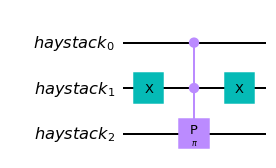

In [2]:
num_qubits = 3
needle = 5

haystack_register = QuantumRegister(num_qubits, name='haystack') # ビット数を指定してレジスタを作る
blackbox_circuit = QuantumCircuit(haystack_register, name='blackbox') # これまでの例と異なり、ビット数ではなくレジスタを指定して回路を作る

for i in range(num_qubits):
    if ((needle >> i) & 1) == 0:
        blackbox_circuit.x(haystack_register[i]) # Xゲートをレジスタのi番目のビットにかける（これまでの例との引数の違いに注意）
        
# レジスタの（0番から）最後から二番目のビットまでで制御し、最後のビットを標的にする
blackbox_circuit.mcp(np.pi, haystack_register[:-1], haystack_register[-1])

# 後片付け
for i in range(num_qubits):
    if ((needle >> i) & 1) == 0:
        blackbox_circuit.x(haystack_register[i])
        
blackbox_circuit.draw('mpl')

ここまでは{doc}`circuit_from_scratch`の問題5と同じです。

Qiskitでは、QuantumCircuitオブジェクト全体を一つのゲートのようにみなして、それから制御ゲートを派生させることができます。

In [3]:
blackbox = blackbox_circuit.to_gate()
cblackbox = blackbox.control(1)

新たに定義した`cblackbox`ゲートは、$n+1$ビット回路に
```{code-block} python
circuit.append(cblackbox, qargs=range(circuit.num_qubits))
```
のようにして組み込むことができます。この場合、0番ビットが制御ビットになります。

それでは、この制御ブラックボックスゲートを利用して、equal superpositionにある`haystack`レジスタで干渉を起こして、観測で`needle`が識別できるような回路を書いてください。（最初の課題なのでかなりヒントがすでに書き込まれています。）

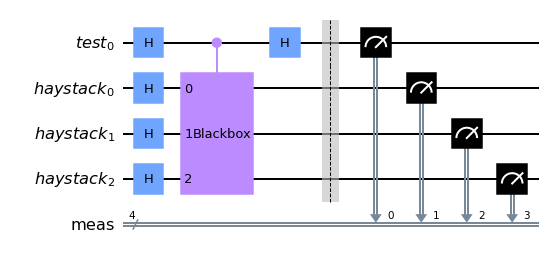

In [4]:
test_register = QuantumRegister(1, 'test')
test = test_register[0]
circuit = QuantumCircuit(test_register, haystack_register)

# equal superpositionを作る（このようにゲート操作のメソッドにレジスタを渡すと、レジスタの各ビットにゲートがかかります。）
circuit.h(haystack_register)

##################
### EDIT BELOW ###
##################
circuit.h(test)

#circuit.?
##################
### EDIT ABOVE ###
##################

circuit.measure_all()

circuit.draw('mpl')

回路が完成したら、{doc}`chsh_inequality`に従って実機で実行し、ヒストグラムをプロットしてください。

In [7]:
from qiskit import IBMQ, execute
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

In [ ]:
IBMQ.enable_account('__paste_your_token_here__')

provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

backend_filter = lambda b: (not b.configuration().simulator) and (b.configuration().n_qubits >= circuit.num_qubits) and b.status().operational
backend = least_busy(provider.backends(filters=backend_filter))

print('Jobs will run on', backend.name())

In [ ]:
job = execute(circuit, backend, shots=8192)
job_monitor(job, interval=2)

result = job.result()
counts = result.get_counts(circuit)

In [ ]:
plot_histogram(counts, figsize=(16, 4))

実機での実行結果が予想と大きく反していたら（ほぼ確実にずれている）、ハードウェアのエラーが起きている可能性があります。そのようなときはシミュレータで回路自体に問題がないか確認します。シミュレータとしては{doc}`circuit_from_scratch`で紹介した`statevector_simulator`を使ってもいいですし（その場合`measure_all()`を除いてください）、`qasm_simulator`という、実機と似た働きをするものを利用することもできます。`qasm_simulator`は回路の測定までをシミュレートするので、実機で実行する場合と同じように位相情報のなくなったヒストグラムデータが出力されます。

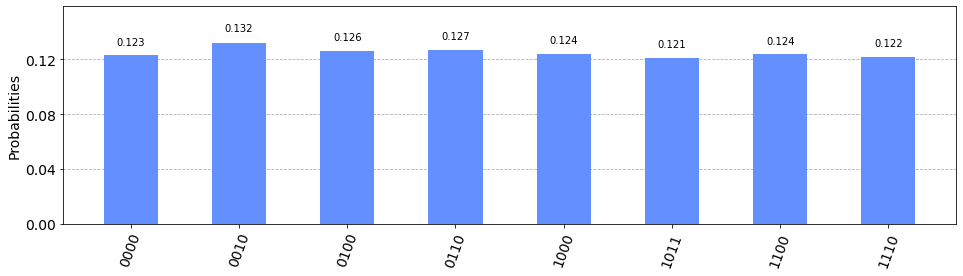

In [10]:
from qiskit import Aer

qasm_simulator = Aer.get_backend('qasm_simulator')
simjob = execute(circuit, qasm_simulator, shots=10000)
plot_histogram(simjob.result().get_counts(), figsize=(16, 4))

**提出するもの**

- 完成した回路のコードと実行結果（実機とシミュレータ）のヒストグラム
- ヒストグラムから何が読み取れるかの考察
- `haystack`レジスタが一般の$n$ビットであるとき、この方法で`needle`を探すことの問題点（実行時間の観点から）に関する考察

## 問題2: データ入力とフーリエ変換

実習で量子フーリエ変換

$$
\ket{j} \xrightarrow{\text{Q.F.T.}} \sum_{k=0}^{2^n-1} e^{2 \pi i j k / 2^n} \ket{k}
$$

を紹介しましたが、これだけだとこの変換が何をするのか、まだピンと来ないかもしれません。

ポイントになるのは、この変換操作が全ての$\ket{j}$に対して作用するということです。なので$\ket{j}$に関する重ね合わせからスタートすると

$$
\begin{align}
\sum_{j=0}^{2^n-1} \varphi_{j} \ket{j} \xrightarrow{\text{Q.F.T.}} & \sum_{k=0}^{2^n-1} \sum_{j=0}^{2^n-1} \varphi_{j} e^{2 \pi i j k / 2^n} \ket{k} \\
=: & \sum_{k=0}^{2^n-1} \tilde{\varphi}_k \ket{k}
\end{align}
$$

となり、$\ket{k}$の振幅が$\varphi_{j}$の離散フーリエ変換$\tilde{\varphi}_k = \sum_{j=0}^{N-1} \exp (2\pi i jk/N) \varphi_j$になっていることがわかります。この$\tilde{\varphi}$の計算は、まさに並列性と干渉の両方を利用した教科書的な量子計算とも言えます。

実習で実装したフーリエ変換のコードを利用して、適当な波形のスペクトル分解をしてみましょう。波形は（古典）データとして配列で与えられるので、それをまずは量子状態に焼き直す必要があります。

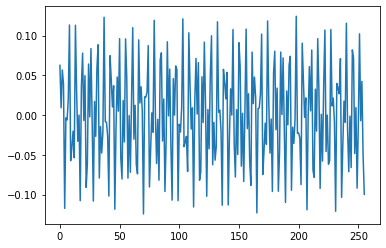

In [22]:
num_qubits = 8
array_length = 2 ** num_qubits

# index array
indices = np.arange(array_length)
# data array = cos(2pi/N * 97 * index) + sin(2pi/N * 43 * index)
data = np.cos(2. * np.pi / array_length * 97 * indices) + np.sin(2. * np.pi / array_length * 43 * indices)
# normalize the data array so sum_i[data_i^2] = 1
data /= np.sqrt(np.sum(np.square(data)))

plt.plot(indices, data)

それでは、この`data`配列が計算基底の振幅に対応するように回路を初期化し、フーリエ変換をしてみましょう。回路の量子ビット数を`num_qubits`のまま組んでみてもいいですし、必要であれば適宜「作業ビット」（計算過程で一時的に情報を書き込んでおくビット）や「補助ビット」（例えばそのビットが$\ket{0}$である部分空間でのみ求める状態が実現しているなど）を足してもOKです。

In [ ]:
circuit = QuantumCircuit(num_qubits)

##################
### EDIT BELOW ###
##################
#circuit.?

##################
### EDIT ABOVE ###
##################

# QFT
for itarg in range(num_qubits - 1, -1, -1):
    circuit.h(itarg)
    for ictrl in range(itarg - 1, -1, -1):
        power = ictrl - itarg - 1 + num_qubits
        circuit.cp((2 ** power) * 2. * np.pi / (2 ** num_qubits), ictrl, itarg)
        
for i in range(num_qubits // 2):
    circuit.swap(i, num_qubits - 1 - i)
    
circuit.measure_all()

出来上がった回路は間違いなく現在の実機で実行できる範囲の制御ビット数を遥かに超えているので、シミュレーションでのみ評価します。

In [ ]:
qasm_simulator = Aer.get_backend('qasm_simulator')
simjob = execute(circuit, qasm_simulator, shots=10000)
plot_histogram(simjob.result().get_counts(), figsize=(16, 4))

**提出するもの**

- 完成した回路のコードと実行結果（シミュレータ）のヒストグラム
- データ入力部分のアルゴリズムの解説
- 古典データを量子回路に入力する際の問題点（必要なゲート数の観点から）に関する考察